## Testing CUBE

In [17]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import rasterio
# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    os_utils,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

In [18]:
# check your collection:


byoc = SentinelHubBYOC(config=config)
print ("START--------------------------START checking your collection...")
# list collections and tiles
# from: https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)

for collection in my_collections:
    
    print("Collection name:", collection["name"])
    print("Collection id: ", collection["id"])
    #tiles = list(byoc.iter_tiles(collection))
    #for tile in tiles:
    #    print("Tile status: ", tile['status'])
    #    print("Tile created: ", tile['created'])
    #    if(tile['status'] == "FAILED"):
    #        print("Ingestion failed error: ", tile['additionalData'])
    print("-------------------")
print ("end")

START--------------------------START checking your collection...
Collection name: UrbanAtlas2018_10m_raster_v1
Collection id:  27c95f8f-fb6b-46f2-8f84-2ce7761eeccd
-------------------
Collection name: urban_audit_2021_city
Collection id:  2bf84477-e224-46f1-8613-7726624d97a0
-------------------
Collection name: urban_audit_2021_city
Collection id:  8d15e636-485a-44cb-93b0-87360e9b2cf1
-------------------
Collection name: UrbanAtlas2018_10m_raster
Collection id:  bc4099db-f686-4e66-99a6-387a11eb2067
-------------------
end


In [3]:
#hhttps://eurodatacube.com/notebooks/curated/EDC_xcube_generator_service.ipynb


x1 = 6  # degree
y1 = 49  # degree
x2 = 7  # degree
y2 = 50  # degree

bbox_lux = x1, y1, x2, y2

resolution = 60
lux_bbox = BBox(bbox=bbox_lux, crs=CRS.WGS84)
lux_size = bbox_to_dimensions(lux_bbox, resolution=resolution)
print(f"Image shape at {resolution} m resolution: {lux_size} pixels")

IPython.display.GeoJSON(shapely.geometry.box(*bbox_lux).__geo_interface__)

Image shape at 60 m resolution: (1268, 1813) pixels


<IPython.display.GeoJSON object>

Image type: uint8


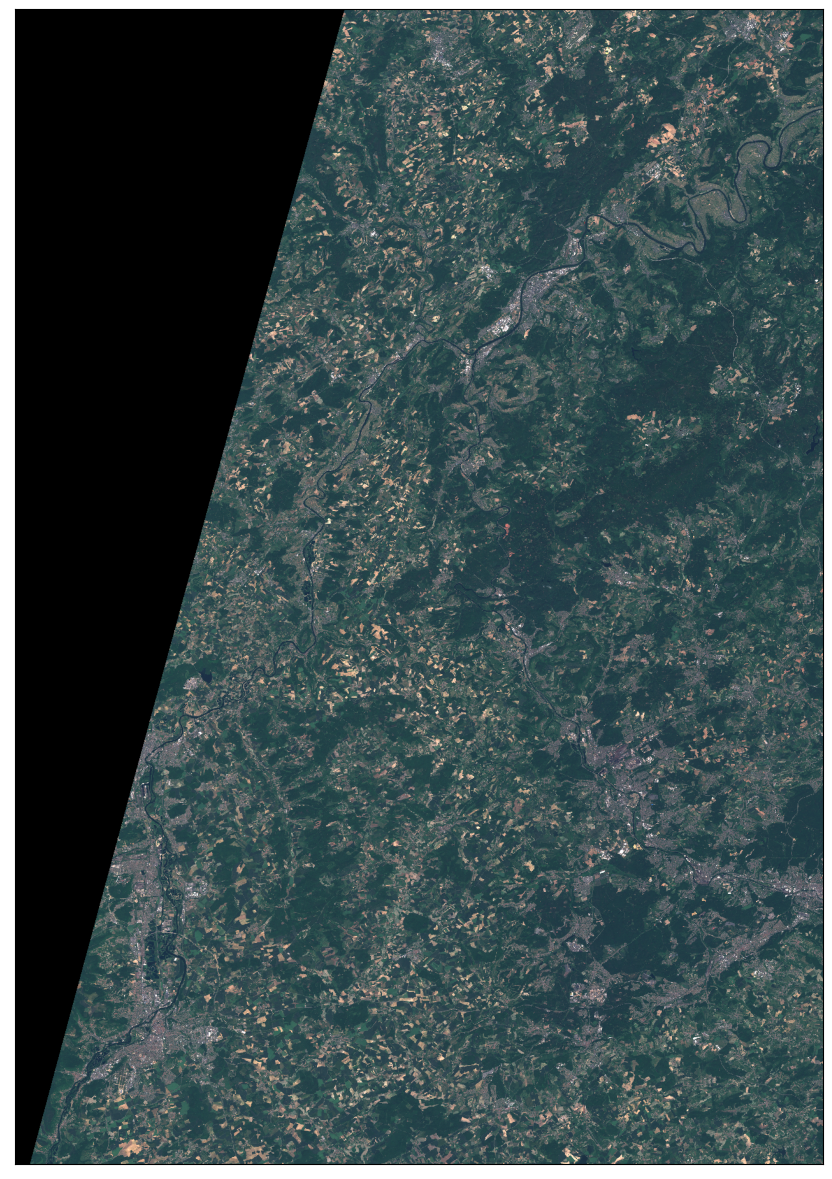

In [4]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2021-06-12", "2021-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=lux_bbox,
    size=lux_size,
    config=config,
)
true_color_imgs = request_true_color.get_data()


#ndvi = NormalizedDifferenceIndexTask(
#    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

START--------------------------
Collection name: UrbanAtlas2018_10m_raster_v1
DataCollection.BYOC_27c95f8f-fb6b-46f2-8f84-2ce7761eeccd
[array([[20707, 21016, 20999, ..., 65535, 65535, 65535],
       [21011, 21000, 21000, ..., 65535, 65535, 65535],
       [21000, 21000, 21000, ..., 65535, 65535, 65535],
       ...,
       [31000, 31000, 31000, ..., 65535, 65535, 65535],
       [31000, 31000, 31000, ..., 65535, 65535, 65535],
       [31000, 31000, 31000, ..., 65535, 65535, 65535]], dtype=int32)]


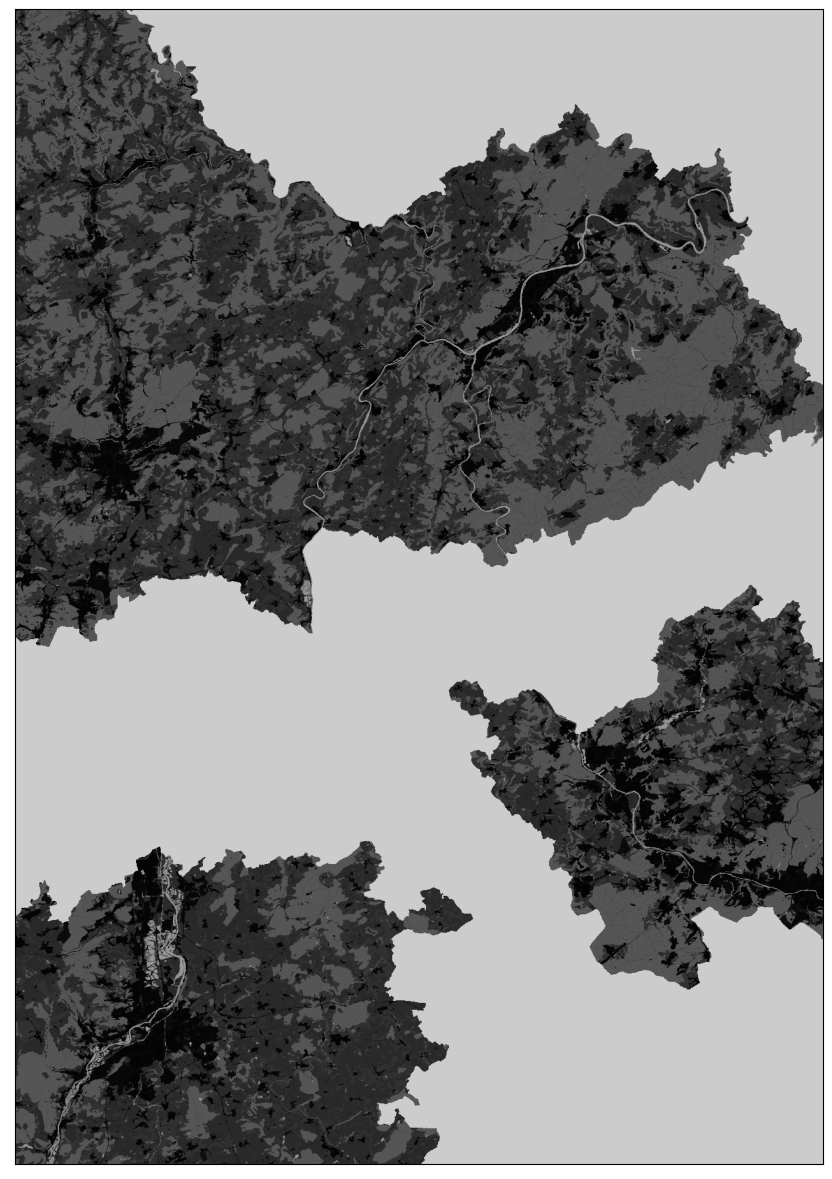

In [29]:
### Urban Atlas data:
 # Initialize SentinelHubBYOC class
    
#############################################################
name_of_your_collection = "UrbanAtlas2018_10m_raster_v1"
#############################################################


byoc = SentinelHubBYOC(config=config)
print ("START--------------------------")
# list collections and tiles
# from: https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
collections_iterator = byoc.iter_collections(name_of_your_collection)
my_collections = list(collections_iterator)[0]

#'UrbanAtlas2018_10m_raster_v1'
#Collection id:  27c95f8f-fb6b-46f2-8f84-2ce7761eeccd
#DataCollection.BYOC_27c95f8f-fb6b-46f2-8f84-2ce7761eeccd
print("Collection name:", my_collections["name"])

    
data_collection = DataCollection.define_byoc(my_collections["id"])
data_collection
print (data_collection)
######################BOX
## plotting test box of you data
#x1 = 6.2  # degree
#y1 = 49.60  # degree
#x2 = 6.34 # degree
#y2 = 49.66  # degree

#bbox = x1, y1, x2, y2
#aoi = BBox([x1, y1, x2, y2], crs=CRS.WGS84)
#spatial_res = 0.00018   # = 20.038 meters in degree
#resolution = 10
#bbox_size = bbox_to_dimensions(aoi, resolution=resolution)
######################BOX

evalscript_ua = """

//VERSION=3
function setup() {
  return {
    input: ["B1"],
    output: { 
        bands: 1 ,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}

function evaluatePixel(sample) {
  return [sample.B1];
}
"""

request_ua = SentinelHubRequest(
        evalscript=evalscript_ua,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection
                #time_interval=tile_time
                # time_interval="2018"
                
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=lux_bbox,
        size=lux_size,

        
    
        config=config
    )
ua_image = request_ua.get_data()

print (ua_image)
#maximum = max(ua_image)
#print (maximum)
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(ua_image)
# ax.set_title(tile_time.date().isoformat(), fontsize=10)
#plt.tight_layout()
plot_image(ua_image[0], factor=1.0, cmap=plt.cm.Greys_r, vmin=10000, vmax=90000)

START--------------------------
Collection name: UrbanAtlas2018_10m_raster_v1
DataCollection.BYOC_27c95f8f-fb6b-46f2-8f84-2ce7761eeccd


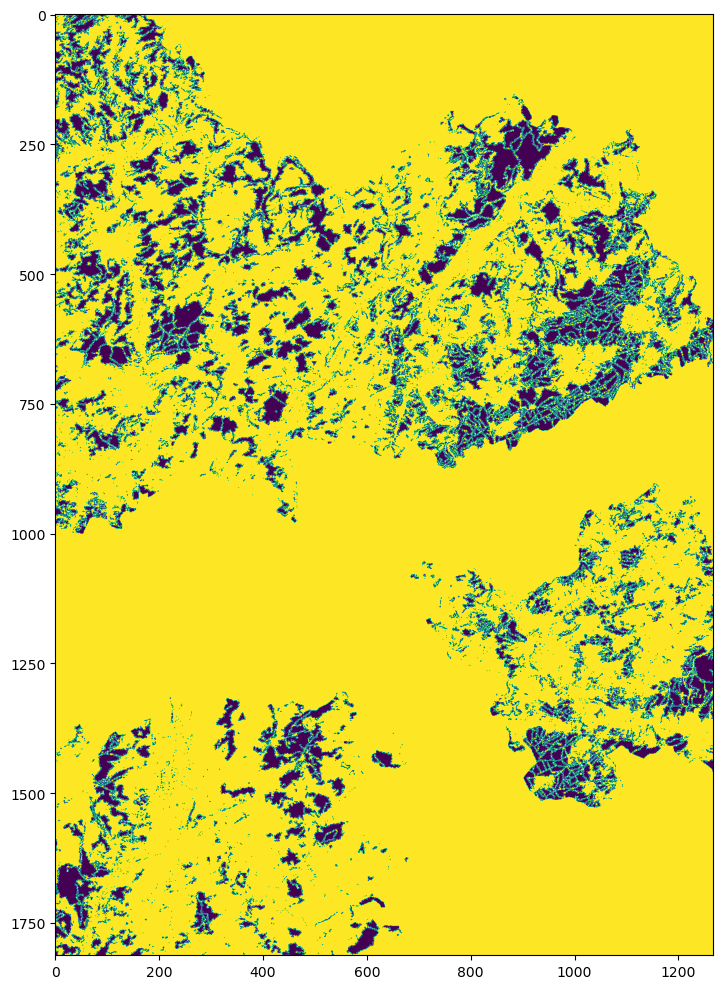

In [48]:
### Urban Atlas data: testing colour  to be updated
 # Initialize SentinelHubBYOC class
    
#############################################################
name_of_your_collection = "UrbanAtlas2018_10m_raster_v1"
#############################################################


byoc = SentinelHubBYOC(config=config)
print ("START--------------------------")
# list collections and tiles
# from: https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html
collections_iterator = byoc.iter_collections(name_of_your_collection)
my_collections = list(collections_iterator)[0]

#'UrbanAtlas2018_10m_raster_v1'
#Collection id:  27c95f8f-fb6b-46f2-8f84-2ce7761eeccd
#DataCollection.BYOC_27c95f8f-fb6b-46f2-8f84-2ce7761eeccd
print("Collection name:", my_collections["name"])

    
data_collection = DataCollection.define_byoc(my_collections["id"])
data_collection
print (data_collection)
######################BOX
## plotting test box of you data
#x1 = 6.2  # degree
#y1 = 49.60  # degree
#x2 = 6.34 # degree
#y2 = 49.66  # degree

#bbox = x1, y1, x2, y2
#aoi = BBox([x1, y1, x2, y2], crs=CRS.WGS84)
#spatial_res = 0.00018   # = 20.038 meters in degree
#resolution = 10
#bbox_size = bbox_to_dimensions(aoi, resolution=resolution)
######################BOX

evalscript_ua = """

//VERSION=3
function setup() {
  return {
    input: ["B1"],
    output: { 
        bands: 1 ,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}
const map_ua = [
	[11100, 0xe6004d] , //11100 - Continuous Urban Fabric (S.L. > 80%)
	[11210, 0xff0000] , //11210 - Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)
	[11220, 0xff0000] , //11220 - Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)
	[11230, 0xff0000] , //11230 - Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)
	[11240, 0xff0000] , //11240 - Discontinuous Very Low Density Urban Fabric (S.L. < 10%)
	[11300, 0xff0000] , //11300 - Isolated Structures
	[12100, 0xcc4df2] , //12100 - Industrial, commercial, public, military and private units
	[12210, 0xcc0000] , //12210 - Fast transit roads and associated land
	[12220, 0xcc0000] , //12220 - Other roads and associated land
	[12230, 0xcc0000] , //12230 - Railways and associated land
	[12300, 0xe6cccc] , //12300 - Port areas
	[12400, 0xe6cce6] , //12400 - Airports
	[13100, 0xa64d00] , //13100 - Mineral extraction and dump sites
	[13300, 0xff4dff] , //13300 - Construction sites
	[13400, 0xff4dff] , //13400 - Land without current use
	[14100, 0xffa6ff] , //14100 - Green urban areas
	[14200, 0xffa6ff] , //14200 - Sports and leisure facilities
	[21000, 0xffffa8] , //21000 - Arable land (annual crops)
	[22000, 0xffff00] , //22000 - Permanent crops (vineyards, fruit trees, olive groves)
	[23000, 0xe6e64d] , //23000 - Pastures
	[24000, 0xffe64d] , //24000 - Complex and mixed cultivation patterns
	[25000, 0xf2cca6] , //25000 - Orchards
	[31000, 0x00a600] , //31000 - Forests
	[32000, 0xa6ff80] , //32000 - Herbaceous vegetation associations (natural grassland, moors…)
	[33000, 0xa6f200] , //33000 - Open spaces with little or no vegetations
	[40000, 0xa6a6ff] , //40000 - Wetland
	[50000, 0x80f2e6] , //50000 - Water bodies
	[91000, 0xffffff] , //91000 - No data (Clouds and shadows)
	[92000, 0xffffff] , //92000 - No data (Missing imagery)

];
const visualizer = new ColorMapVisualizer(map_ua);


function evaluatePixel(sample) {
  let rgbVis = visualizer.process(sample.B1);
  return rgbVis.concat(sample.B1);

}
"""

request_ua = SentinelHubRequest(
        evalscript=evalscript_ua,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection
                #time_interval=tile_time
                # time_interval="2018"
                
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=lux_bbox,
        size=lux_size,

        
    
        config=config
    )
ua_image = request_ua.get_data()

#maximum = max(ua_image)
#print (maximum)
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(ua_image)
# ax.set_title(tile_time.date().isoformat(), fontsize=10)
#plt.tight_layout()

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(ua_image[0])
# ax.set_title(tile_time.date().isoformat(), fontsize=10)

plt.tight_layout()

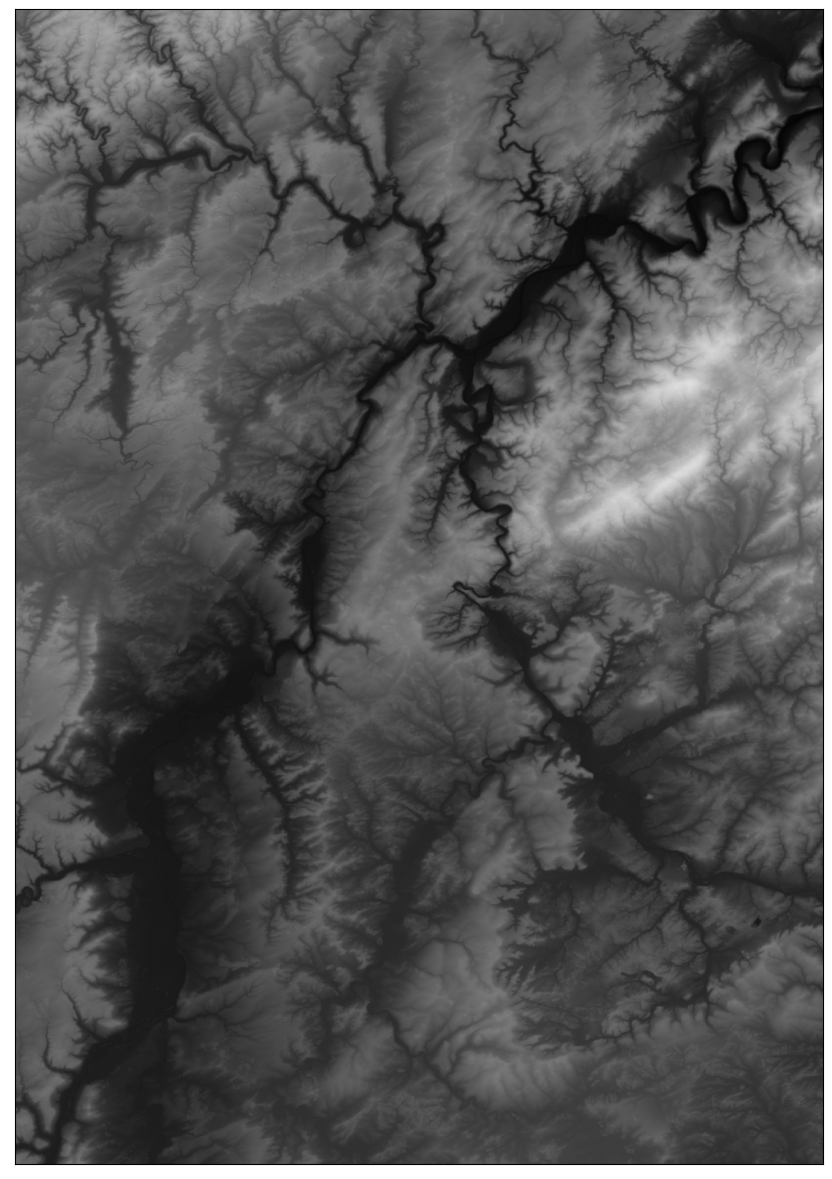

In [30]:
##DEM

evalscript_dem = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""
dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=lux_bbox,
    size=lux_size,
    config=config,
)

dem_data = dem_request.get_data()
# Plot DEM map
# vmin = 0; cutoff at sea level (0 m)
# vmax = 120; cutoff at high values (120 m)
plot_image(dem_data[0], factor=1.0, cmap=plt.cm.Greys_r, vmin=90, vmax=900)

end


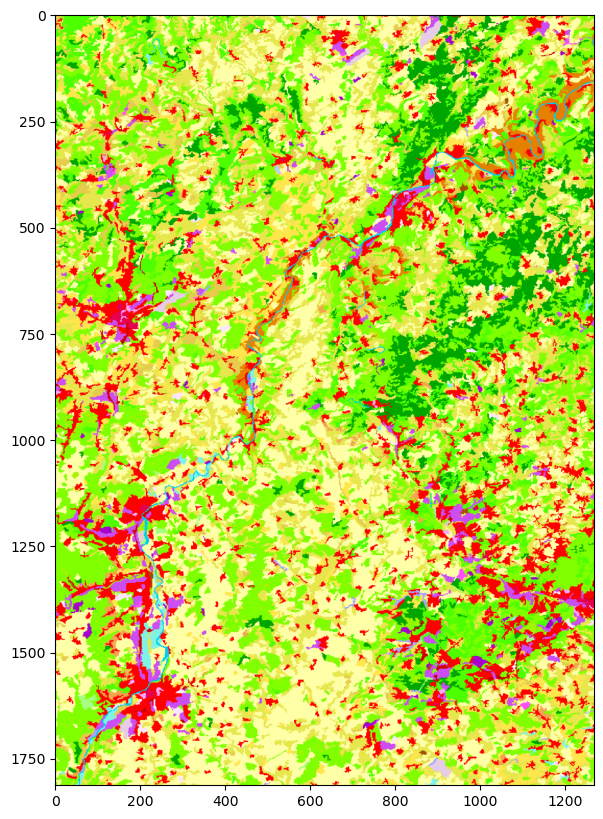

In [60]:
##CLC
##https://custom-scripts.sentinel-hub.com/copernicus_services/corine_land_cover/

##https://collections.eurodatacube.com/corine-land-cover-accounting-layers/
##End point
##https://creodias.sentinel-hub.com
##Type
##byoc-4c5441a6-6040-4dc4-a392-c1317bbd1031
##collectionId
##4c5441a6-6040-4dc4-a392-c1317bbd1031
##xcube Resources
##dataset_name
##CUSTOM
##collectionId
##4c5441a6-6040-4dc4-a392-c1317bbd1031

##reading CLC

## check config file for correct END POINT
config2 = config
config2.sh_base_url = "https://creodias.sentinel-hub.com"
#print(config2)

collection_id = '4c5441a6-6040-4dc4-a392-c1317bbd1031'
byoc = DataCollection.define_byoc(collection_id, name="CLC_ACC", is_timeless=True)
byoc
######


evalscript_clc = """
//VERSION=3
// This script visualises Corine Land Cover Accounting Layers
function setup() {
  return {
    input: ["CLC_ACC", "dataMask"],
    output: { bands: 4 }
  }
}

const map = [
  [111, 0xe6004d],  //111 - Continuous urban fabric
  [112, 0xff0000],  //112 - Discontinuous urban fabric
  [121, 0xcc4df2],  //121 - Industrial or commercial units
  [122, 0xcc0000],  //122 - Road and rail networks and associated land
  [123, 0xe6cccc],  //123 - Port areas
  [124, 0xe6cce6],  //124 - Airports
  [131, 0xa600cc],  //131 - Mineral extraction sites
  [132, 0xa64d00],  //132 - Dump sites
  [133, 0xff4dff],  //133 - Construction sites
  [141, 0xffa6ff], //141 - Green urban areas
  [142, 0xffe6ff], //142 - Sport and leisure facilities
  [211, 0xffffa8], //211 - Non-irrigated arable land
  [212, 0xffff00], //212 - Permanently irrigated land
  [213, 0xe6e600], //213 - Rice fields
  [221, 0xe68000], //221 - Vineyards
  [222, 0xf2a64d], //222 - Fruit trees and berry plantations
  [223, 0xe6a600], //223 - Olive groves
  [231, 0xe6e64d], //231 - Pastures
  [241, 0xffe6a6], //241 - Annual crops associated with permanent crops
  [242, 0xffe64d], //242 - Complex cultivation patterns
  [243, 0xe6cc4d], //243 - Land principally occupied by agriculture with significant areas of natural vegetation
  [244, 0xf2cca6], //244 - Agro-forestry areas
  [311, 0x80ff00], //311 - Broad-leaved forest
  [312, 0x00a600], //312 - Coniferous forest
  [313, 0x4dff00], //313 - Mixed forest
  [321, 0xccf24d], //321 - Natural grasslands
  [322, 0xa6ff80], //322 - Moors and heathland
  [323, 0xa6e64d], //323 - Sclerophyllous vegetation
  [324, 0xa6f200], //324 - Transitional woodland-shrub
  [331, 0xe6e6e6], //331 - Beaches - dunes - sands
  [332, 0xcccccc], //332 - Bare rocks
  [333, 0xccffcc], //333 - Sparsely vegetated areas
  [334, 0x000000], //334 - Burnt areas
  [335, 0xa6e6cc], //335 - Glaciers and perpetual snow
  [411, 0xa6a6ff], //411 - Inland marshes
  [412, 0x4d4dff], //412 - Peat bogs
  [421, 0xccccff], //421 - Salt marshes
  [422, 0xe6e6ff], //422 - Salines
  [423, 0xa6a6e6], //423 - Intertidal flats
  [511, 0x00ccf2], //511 - Water courses
  [512, 0x80f2e6], //512 - Water bodies
  [521, 0x00ffa6], //521 - Coastal lagoons
  [522, 0xa6ffe6], //522 - Estuaries
  [523, 0xe6f2ff], //523 - Sea and ocean
  [999, 0xffffff]  //999 - NODATA
];

const visualizer = new ColorMapVisualizer(map);

function evaluatePixel(sample) {
  let rgbVis = visualizer.process(sample.CLC_ACC);
  return rgbVis.concat(sample.dataMask);
}
"""

clc_request = SentinelHubRequest(
    evalscript=evalscript_clc,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.CLC_ACC,
            time_interval=("2018-01-01", "2019-01-01"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=lux_bbox,
    size=lux_size,
    config=config2,
)

clc_data = clc_request.get_data()




# Plot DEM map
# vmin = 0; cutoff at sea level (0 m)
# vmax = 120; cutoff at high values (120 m)
#plot_image(clc_data, factor=3.5 / 255, clip_range=(0, 1))


fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(clc_data[0])


# ax.set_title(tile_time.date().isoformat(), fontsize=10)

#plt.tight_layout()


print ("end")

ImportError: cannot import name 'DataSource' from 'sentinelhub' (/home/conda/fairicube/509ef1ea91778cd89e0732da937c672a0e4c27fd9e360fadaa9831b15c3fb15c-20230123-091006-736556-1-edc-2022.10-14/lib/python3.9/site-packages/sentinelhub/__init__.py)